# CNN Pytorch - Histopathologic Cancer Detection

## Description

### Description of Kaggle Competition

This notebook contains the code used for the Histopathologic Cancer Detection Kaggle competition (link: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). 

The following description is taken from the Kaggle website:

*In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).*

### Description of  Dataset

The following description of the dataset is taken from the Kaggle website:

*In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.*


## Import Libaries

In [1]:
import os 

import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Create Training and Validation Datasets

In [11]:
# Import labels for training data
train_labels = pd.read_csv('train_labels.csv')

# Explore file
print(train_labels.head())

#  Dividing training data into training and validation sets
train_df, val_df = train_test_split(train_labels, test_size = 0.2, random_state = 42, stratify = train_labels['label'])

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Create filename column (id + '.tif')
train_df['filename'] = train_df['id'] + '.tif'
val_df['filename'] = val_df['id'] + '.tif'

# Explore updated format of the training and validation sets
print(train_df.head())

# Explore training and validation set size
print(f"Size of training set: {len(train_df)}")
print(f"Size of validation set: {len(val_df)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                              id label  \
198607  cffe7a3ffc48700045fd37f1f448b5a892ff4f2c     0   
14684   b5bef3e7d7e8cc81e38fa2288105fc1c130e771a     0   
55923   6fe4413a3a982af28a6e78d0f445073c509b4b33     0   
215817  d6b4fe580210f5ea61b7c109b5c2e5cc734c3010     0   
10219   1b6b051e370ca8468253d2e40f686c66eecb1619     1   

                                            filename  
198607  cffe7a3ffc48700045fd37f1f448b5a892ff4f2c.tif  
14684   b5bef3e7d7e8cc81e38fa2288105fc1c130e771a.tif  
55923   6fe4413a3a982af28a6e78d0f445073c509b4b33.tif  
215817  d6b4fe580210f5ea61b7c109b5c2e5cc734c3010.tif  
10219   1b6b051e370ca8468253d2e40f686c66eecb1619.tif  
Size of trainin

## Exploratory Data Analysis

Explore the frequency of labels in the training and validation set

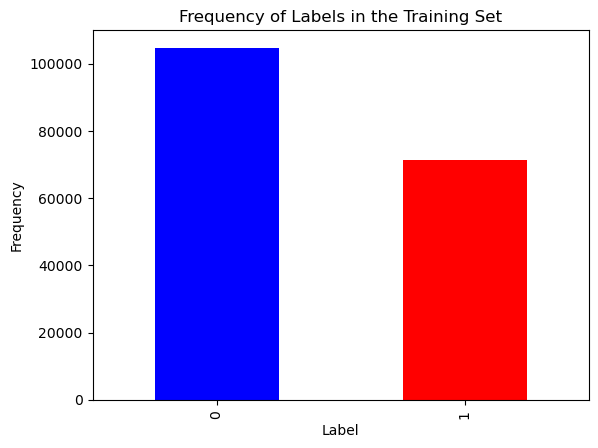

label
0    104726
1     71294
Name: count, dtype: int64


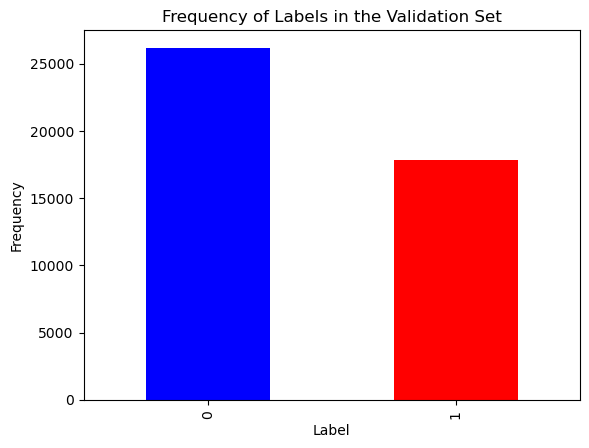

label
0    26182
1    17823
Name: count, dtype: int64


In [11]:
# Training set
train_df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Frequency of Labels in the Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(train_df['label'].value_counts())

# Validation set
val_df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Frequency of Labels in the Validation Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(val_df['label'].value_counts())

Looks like there is a good mix of negative (0) and positive (1) cases.

Next, examine a few images contained in the training set. Some images have a label of 0, and some have a label of 1.

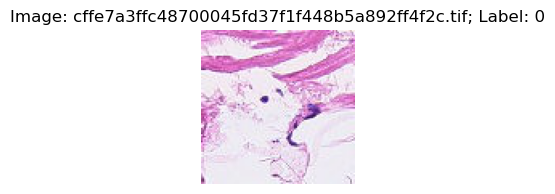

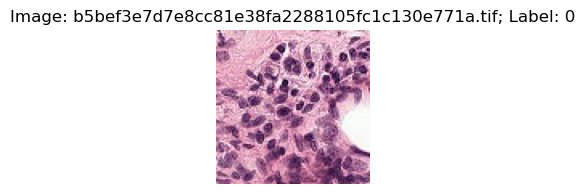

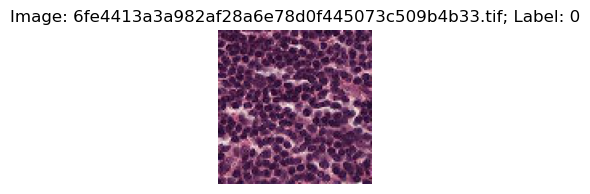

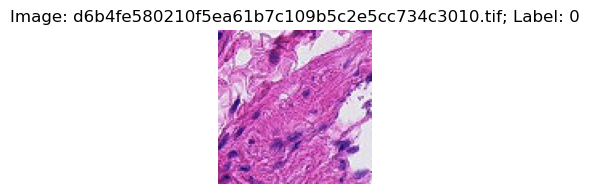

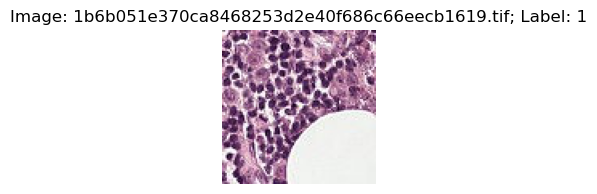

In [12]:
train_dir = os.path.join(os.getcwd() + '\\train\\train\\')

for i in range(5):
    image = train_df['filename'].iloc[i]
    label = train_df['label'].iloc[i]
    
    image_open = Image.open(os.path.join(train_dir, image))
    
    plt.figure(figsize=(4, 2))
    plt.imshow(image_open)
    plt.title(f'Image: {image}; Label: {label}')
    plt.axis('off')
    plt.show()

## Model Architecture

Due to their effectiveneses for image classfication, we will use Convolutional Neural Networks (CNNs).

We will create the following models:
- Baseline model
- More layers model
- More layers with dropout model

The hypothesis is that adding more neurons and layers will allow the model to pick up on more complex features. To prevent overfitting, we will also test the impact of adding dropout.

In [7]:
def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def create_layers_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

layers_model = create_layers_model()
layers_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,200,961 (50.36 MB)

 Trainable params: 13,200,961 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def create_layers_dropout_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        Flatten(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

layers_dropout_model = create_layers_dropout_model()
layers_dropout_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,200,961 (50.36 MB)

 Trainable params: 13,200,961 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

## Data Preprocessing

First, create data generators

In [13]:
# Create image data generators
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = 'binary'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = 'binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Compile Models

Now, we compile the models. We will use accuracy as the metric of interest as this is the metric that will be used to assess model performance in the Kaggle competition.

In [11]:
# Compile models
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
layers_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
layers_dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

In this step, we train the 3 models compiled in the prior step.

In [11]:
baseline_model_train = baseline_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1293s 235ms/step - accuracy: 0.7706 - loss: 0.4740 - val_accuracy: 0.8315 - val_loss: 0.3802
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1251s 227ms/step - accuracy: 0.8301 - loss: 0.3839 - val_accuracy: 0.8342 - val_loss: 0.3686
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1840s 334ms/step - accuracy: 0.8485 - loss: 0.3503 - val_accuracy: 0.8617 - val_loss: 0.3326
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2191s 398ms/step - accuracy: 0.8628 - loss: 0.3213 - val_accuracy: 0.8580 - val_loss: 0.3321
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2279s 414ms/step - accuracy: 0.8740 - loss: 0.2989 - val_accuracy: 0.8772 - val_loss: 0.2952
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1251s 227ms/step - accuracy: 0.8825 - loss: 0.2832 - val_accuracy: 0.8584 - val_loss: 0.3268
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1693s 308ms/step - accuracy: 0.8892 - loss: 0.2689 - val_accuracy: 0.8609 - val_loss: 0.3120
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2328s 423ms/s

In [12]:
layers_model_train = layers_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2122s 385ms/step - accuracy: 0.7832 - loss: 0.4702 - val_accuracy: 0.8577 - val_loss: 0.3321
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2160s 393ms/step - accuracy: 0.8578 - loss: 0.3332 - val_accuracy: 0.8804 - val_loss: 0.2895
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2156s 392ms/step - accuracy: 0.8771 - loss: 0.2955 - val_accuracy: 0.8872 - val_loss: 0.2782
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2156s 392ms/step - accuracy: 0.8893 - loss: 0.2710 - val_accuracy: 0.8949 - val_loss: 0.2573
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2166s 394ms/step - accuracy: 0.8993 - loss: 0.2495 - val_accuracy: 0.8904 - val_loss: 0.2663
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2161s 393ms/step - accuracy: 0.9044 - loss: 0.2391 - val_accuracy: 0.9065 - val_loss: 0.2400
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2231s 406ms/step - accuracy: 0.9133 - loss: 0.2221 - val_accuracy: 0.9148 - val_loss: 0.2175
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2217s 403ms/s

In [17]:
layers_droupout_model_train = layers_dropout_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2063s 375ms/step - accuracy: 0.8781 - loss: 0.2961 - val_accuracy: 0.8948 - val_loss: 0.2602
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2040s 371ms/step - accuracy: 0.8872 - loss: 0.2756 - val_accuracy: 0.8995 - val_loss: 0.2520
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2045s 372ms/step - accuracy: 0.8915 - loss: 0.2695 - val_accuracy: 0.8964 - val_loss: 0.2631
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 3575s 650ms/step - accuracy: 0.8952 - loss: 0.2602 - val_accuracy: 0.9027 - val_loss: 0.2476
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 3736s 679ms/step - accuracy: 0.8988 - loss: 0.2565 - val_accuracy: 0.9086 - val_loss: 0.2373
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 3777s 687ms/step - accuracy: 0.8992 - loss: 0.2522 - val_accuracy: 0.9095 - val_loss: 0.2291
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2110s 383ms/step - accuracy: 0.9019 - loss: 0.2462 - val_accuracy: 0.9158 - val_loss: 0.2141
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2110s 384ms/s

In [23]:
# Save model for later
layers_dropout_model.save("layers_dropout_model.keras")

## Model Evaluation

Now that the models have been trained, let's visualize their accuracy over epochs.

In [15]:
def create_plot(trained_model, title):
    plt.figure(figsize = (12, 4))
    plt.plot(trained_model.history['accuracy'], label='Training Set')
    plt.plot(trained_model.history['val_accuracy'], label='Validation Set')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

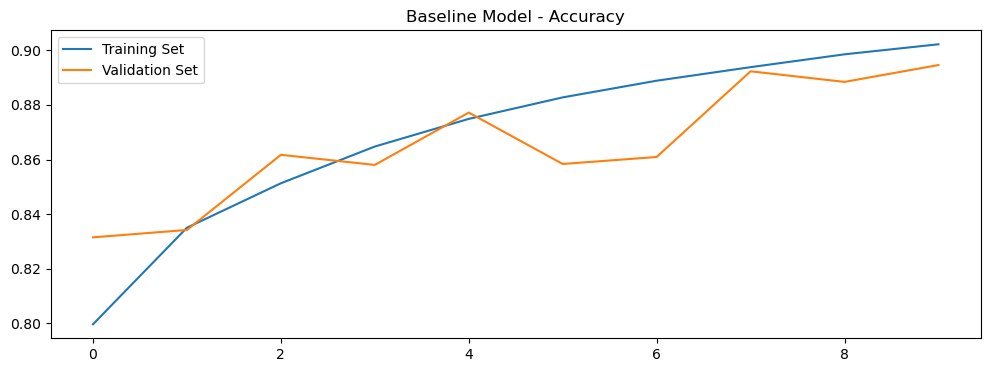

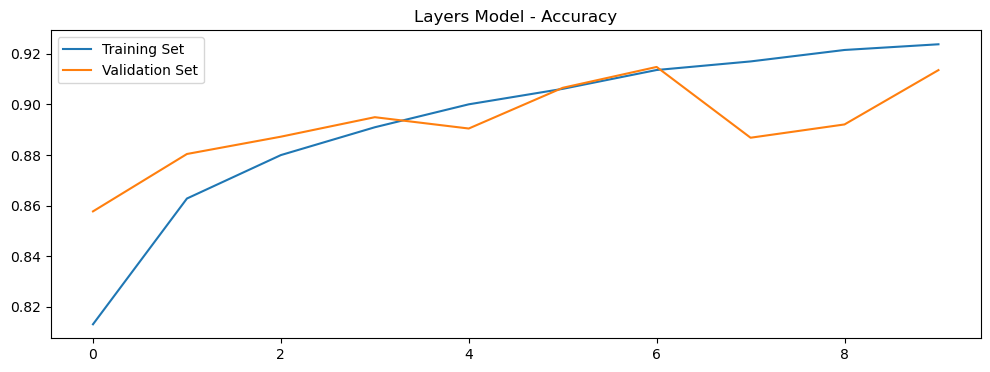

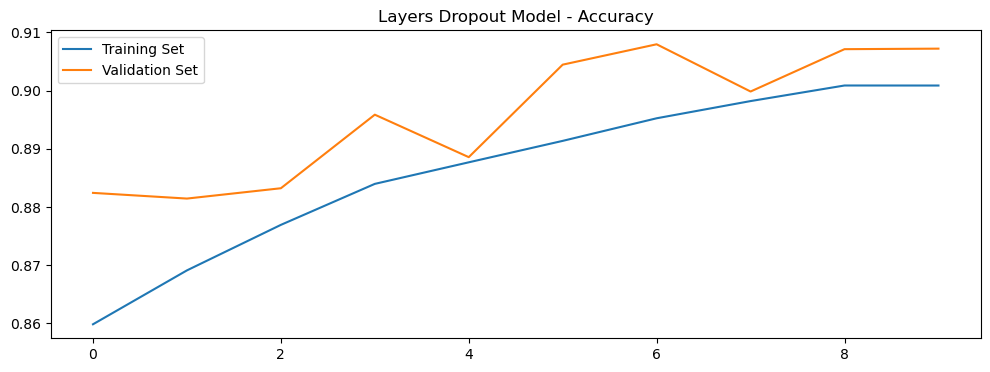

In [17]:
create_plot(baseline_model_train, 'Baseline Model')
create_plot(layers_model_train, 'Layers Model')
create_plot(layers_droupout_model_train, 'Layers Dropout Model')

Adding additional layers/neurons improved the accuracy of the model by allowing the model to pick up on more complex associations. Adding dropout led to slightly improved the accuracy on the validation set as compared to the training set albeit the difference was quite small.

## Hyperparemeter Tuning

Next, we experiment with hyperparameter tuning.

Based on our evaluation of the three models above, we have already observed the impact of the following:
- Number of layers/neurons: Increasing the number of layers/neurons appears to improve the ability of the model to detect complex associations
- Number of epochs: using a higher number of epochs during training appeared to increase the accuracy of the model in both the training and validation sets
- Dropout: adding dropout to the model appeared to improve the accuracy of the model in the validation set by preventing overfitting albeit the effect was quite small in this case


Next, we'll test the impact of the following hyperparameters
- Changing the batch size (16 vs. 32 (default) vs. 64)
- Changing the learning rate (0.001 (default) vs. 0.5 vs. 5)

Note, hyperparameter tuning is being performed to explore, descriptively, the impact of modifying the hyperparameters. For these purposes, we will use a lower number of epochs (5), which should be sufficient to explore the impact of modifying the hyperparameters.

First, let's explore the impact of changing the batch size.

In [12]:
# Data generators with batch size of 16
train_generator_16 = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 16,
    class_mode = 'binary'
)
val_generator_16 = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 16,
    class_mode = 'binary'
)

# Data generators with batch size of 64
train_generator_64 = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 64,
    class_mode = 'binary'
)
val_generator_64 = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 64,
    class_mode = 'binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [24]:
# Model with dropout with a batch size of 16
layers_droupout_model_train_16 = layers_dropout_model.fit(
    train_generator_16,
    epochs = 5,
    validation_data = val_generator_16
)

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 2979s 270ms/step - accuracy: 0.7710 - loss: 0.4841 - val_accuracy: 0.8256 - val_loss: 0.3941
Epoch 2/5
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 3014s 274ms/step - accuracy: 0.8478 - loss: 0.3547 - val_accuracy: 0.8368 - val_loss: 0.3859
Epoch 3/5
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 2928s 266ms/step - accuracy: 0.8583 - loss: 0.3355 - val_accuracy: 0.8684 - val_loss: 0.3124
Epoch 4/5
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 2907s 264ms/step - accuracy: 0.8642 - loss: 0.3222 - val_accuracy: 0.8437 - val_loss: 0.3774
Epoch 5/5
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 2934s 267ms/step - accuracy: 0.8696 - loss: 0.3141 - val_accuracy: 0.8335 - val_loss: 0.4103


In [13]:
# Model with dropout with a batch size of 64
layers_dropout_model_train_64 = layers_dropout_model.fit(
    train_generator_64,
    epochs = 5,
    validation_data = val_generator_64
)

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1860s 675ms/step - accuracy: 0.7479 - loss: 0.5625 - val_accuracy: 0.8202 - val_loss: 0.4002
Epoch 2/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1731s 629ms/step - accuracy: 0.8335 - loss: 0.3863 - val_accuracy: 0.8616 - val_loss: 0.3328
Epoch 3/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1740s 632ms/step - accuracy: 0.8603 - loss: 0.3285 - val_accuracy: 0.8808 - val_loss: 0.2852
Epoch 4/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1732s 629ms/step - accuracy: 0.8739 - loss: 0.3041 - val_accuracy: 0.8891 - val_loss: 0.2775
Epoch 5/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1923s 699ms/step - accuracy: 0.8827 - loss: 0.2849 - val_accuracy: 0.8717 - val_loss: 0.3078


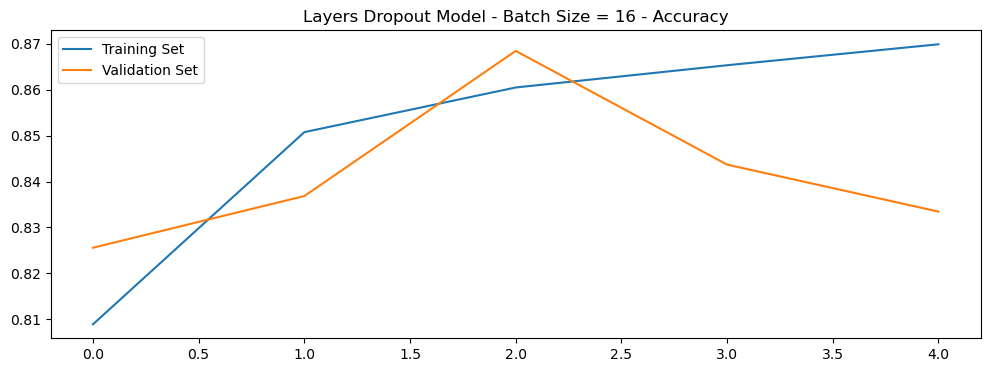

In [26]:
create_plot(layers_droupout_model_train_16, 'Layers Dropout Model - Batch Size = 16')

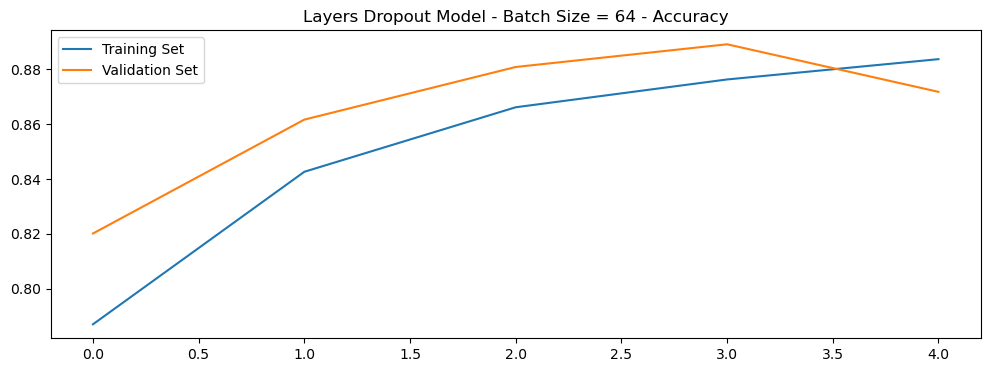

In [16]:
create_plot(layers_dropout_model_train_64, 'Layers Dropout Model - Batch Size = 64')

The larger batch size (64) trained faster and had better accuracy in the training/validation sets as compared to the smaller batch size (16). However, the batch size of 32 had the best accuracy in the training/validation sets after 5 epochs.

Next, let's explore the impact of tuning the learning rate.

In [18]:
# Create optimizers
optimizer_05 = tf.keras.optimizers.Adam(learning_rate = 0.5)
optimizer_5 = tf.keras.optimizers.Adam(learning_rate = 5.0)

# Create models -- same as prior but we will change learning rate during compiling
layers_dropout_model_lr05 = create_layers_dropout_model()
layers_dropout_model_lr5 = create_layers_dropout_model()

# Compile models
layers_dropout_model_lr05.compile(optimizer=optimizer_05, loss='binary_crossentropy', metrics=['accuracy'])
layers_dropout_model_lr5.compile(optimizer=optimizer_5, loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Fit model with learning rate of 0.5
layers_dropout_model_lr05_train = layers_dropout_model_lr05.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator
)

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2080s 378ms/step - accuracy: 0.5751 - loss: 783955.7500 - val_accuracy: 0.5950 - val_loss: 0.6819
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2014s 366ms/step - accuracy: 0.5761 - loss: 0.6852 - val_accuracy: 0.4050 - val_loss: 0.7076
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2035s 370ms/step - accuracy: 0.5800 - loss: 0.6844 - val_accuracy: 0.5950 - val_loss: 0.6791
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2071s 376ms/step - accuracy: 0.5788 - loss: 0.6844 - val_accuracy: 0.5950 - val_loss: 0.6800
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2085s 379ms/step - accuracy: 0.5777 - loss: 0.6856 - val_accuracy: 0.5950 - val_loss: 0.6832


In [23]:
# Fit model with learning rate of 5
layers_dropout_model_lr5_train = layers_dropout_model_lr5.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2157s 391ms/step - accuracy: 0.5410 - loss: 415533924352.0000 - val_accuracy: 0.5950 - val_loss: 0.7296
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2129s 387ms/step - accuracy: 0.5392 - loss: 0.7506 - val_accuracy: 0.4050 - val_loss: 0.7490
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2133s 388ms/step - accuracy: 0.5381 - loss: 0.7427 - val_accuracy: 0.5950 - val_loss: 0.6825
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2143s 389ms/step - accuracy: 0.5476 - loss: 0.7384 - val_accuracy: 0.5950 - val_loss: 0.6837
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2158s 392ms/step - accuracy: 0.5412 - loss: 0.7347 - val_accuracy: 0.5950 - val_loss: 0.7550


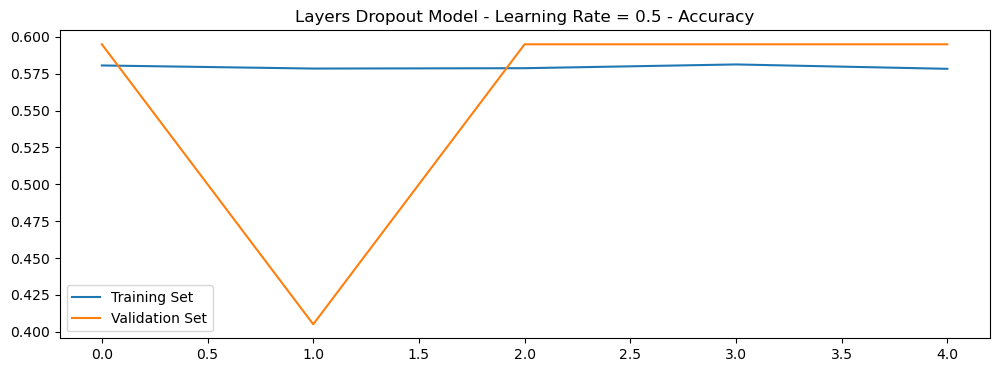

In [22]:
create_plot(layers_dropout_model_lr05_train, 'Layers Dropout Model - Learning Rate = 0.5')

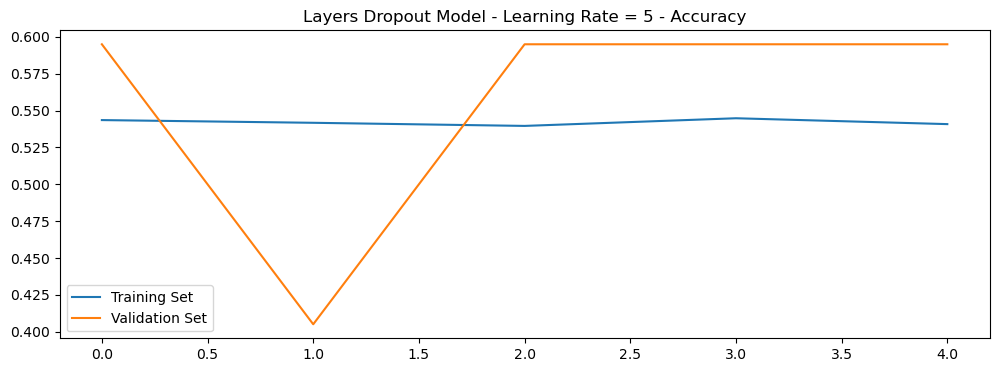

In [24]:
create_plot(layers_dropout_model_lr5_train, 'Layers Dropout Model - Learning Rate = 5')

At high learning rates (0.50 and 5.00), the accuracy of the models did not improve over 5 epochs in the training set. It seems that a lower learning rate improves the stability of learning.

## Applying Model to Test Set

The "layers_dropout_model", which had an additional layer with more neurons and dropout, performed the best in terms of accuracy in the validation set. As a result, we'll apply this model to the test set.

In [43]:
# Create test dataset
test_dir = os.path.join(os.getcwd() + '\\test\\test\\')
test_files = os.listdir(test_dir)
test_df = pd.DataFrame({'filenames': test_files})
# In order to force the generator to contain the correct format, create meaningless 'label' column
test_df['label'] = str(0)
test_df['label'][0] = str(1)

# Create generator for test data
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col = 'filenames',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False
)

Found 57458 validated image filenames belonging to 2 classes.


In [26]:
# Load model
layers_dropout_model = tf.keras.models.load_model("layers_dropout_model.keras")

# Examine the layout of the sample file
pd.read_csv('sample_submission.csv').head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [44]:
# Predict labels using model
test_generator.reset()
pred = layers_dropout_model.predict(test_generator, verbose = 1)

    6/57458 ━━━━━━━━━━━━━━━━━━━━ 10:04 11ms/step

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 586s 10ms/step


In [57]:
# Prepare data for submission
submission_df = test_df
submission_df['id'] = submission_df['filenames'].str.replace('.tif', '', regex = False)
submission_df['label'] = pred
submission_df = submission_df[['id', 'label']]

# Preview data for submission
print(submission_df.head())

# Save data for submission to csv
submission_df.to_csv('submission_df.csv', index = False)

                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.999794
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.990902
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.814796
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.037746
4  000270442cc15af719583a8172c87cd2bd9c7746  0.012290


Now that we have applied our model to the test set and created the subsmission data file, we are ready to turn our results in to the Kaggle competition for grading. Looks like we achieved public score of 0.9399. Great!

## Conclusion

In this project, we trained a CNN to identify cases of cancer from pathology scans. We found that training a deeper network (more layers) with more neurons allowed us to detect more complex associations, adding dropout helped to prevent overfitting, and that modifying the batch size impacted model accuracy and training time. The model that was developed during this project achieved a public score of 0.9399 in the Kaggle competition, indicating that it performed quite well relative to other models in the competition. Indeed, the accuracy of the model during training was over 90% in the validation set indicating the model had excellent accuracy.